# Project - Sales Forecasting Accuracy Increasing 

In [213]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from scipy.optimize import minimize
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt

In [214]:
data = pd.read_csv('For USML.csv', sep=";")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 13 columns):
Period        81 non-null int64
Forecast 1    81 non-null int64
Actual 1      81 non-null int64
Forecast 2    81 non-null int64
Actual 2      81 non-null int64
Forecast 3    81 non-null int64
Actual 3      81 non-null int64
Forecast 4    81 non-null int64
Actual 4      81 non-null int64
Forecast 5    81 non-null int64
Actual 5      81 non-null int64
Forecast 6    81 non-null int64
Actual 6      81 non-null int64
dtypes: int64(13)
memory usage: 8.3 KB


In [215]:
data.describe()

,Period,Forecast 1,Actual 1,Forecast 2,Actual 2,Forecast 3,Actual 3,Forecast 4,Actual 4,Forecast 5,Actual 5,Forecast 6,Actual 6
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,41.000000,9056.345679,8701.000000,878.074074,992.444444,3416.753086,3237.037037,891.358025,881.888889,48.876543,165.148148,57.925926,105.925926
std,23.526581,2793.121874,2573.329633,463.331193,705.503774,1032.982424,1084.246391,380.930220,645.320754,70.220792,360.988300,80.966162,160.372830
min,1.000000,2940.000000,3885.000000,269.000000,72.000000,1500.000000,858.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,6830.000000,6867.000000,525.000000,537.000000,2640.000000,2382.000000,600.000000,408.000000,0.000000,42.000000,0.000000,12.000000
50%,41.000000,9150.000000,8109.000000,840.000000,834.000000,3300.000000,3345.000000,870.000000,738.000000,0.000000,90.000000,0.000000,51.000000
75%,61.000000,10620.000000,10611.000000,1050.000000,1311.000000,4050.000000,3762.000000,1095.000000,1182.000000,90.000000,156.000000,120.000000,120.000000
max,81.000000,15150.000000,15396.000000,3099.000000,3966.000000,5850.000000,7365.000000,1827.000000,3270.000000,426.000000,3180.000000,291.000000,879.000000


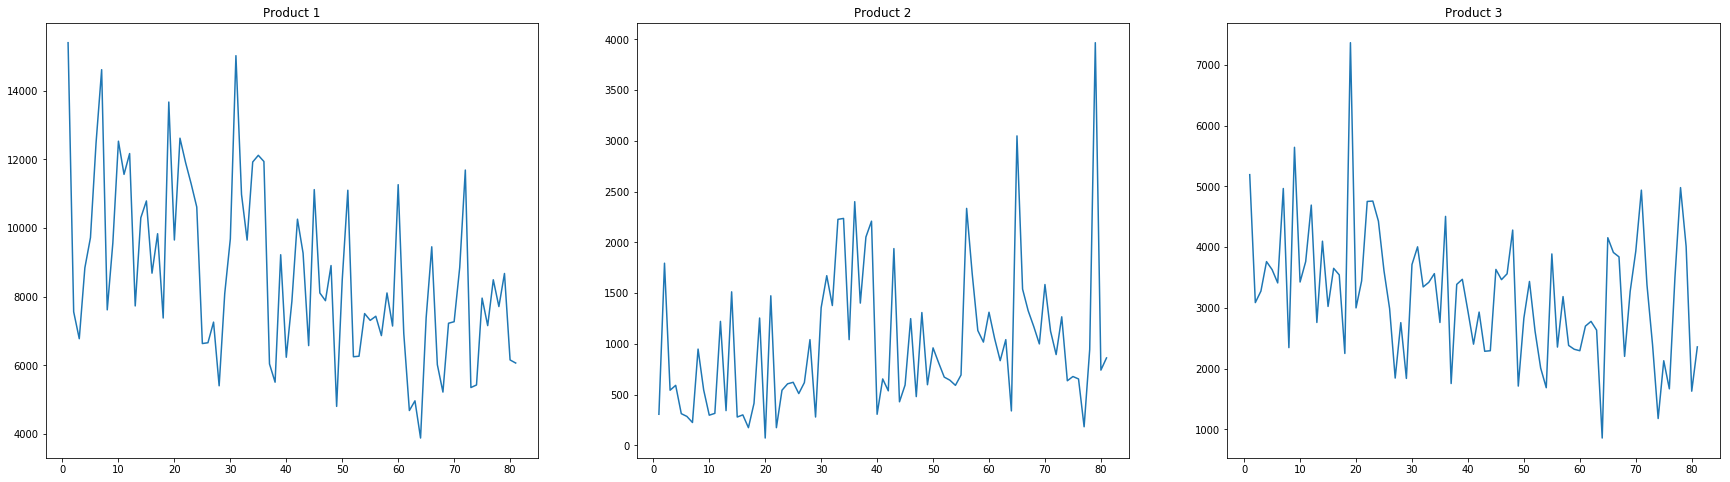

In [216]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 8));
axes[0].plot(data["Period"],data["Actual 1"]);
axes[0].set_title("Product 1");
axes[1].plot(data["Period"],data["Actual 2"]);
axes[1].set_title("Product 2");
axes[2].plot(data["Period"],data["Actual 3"]);
axes[2].set_title("Product 3");

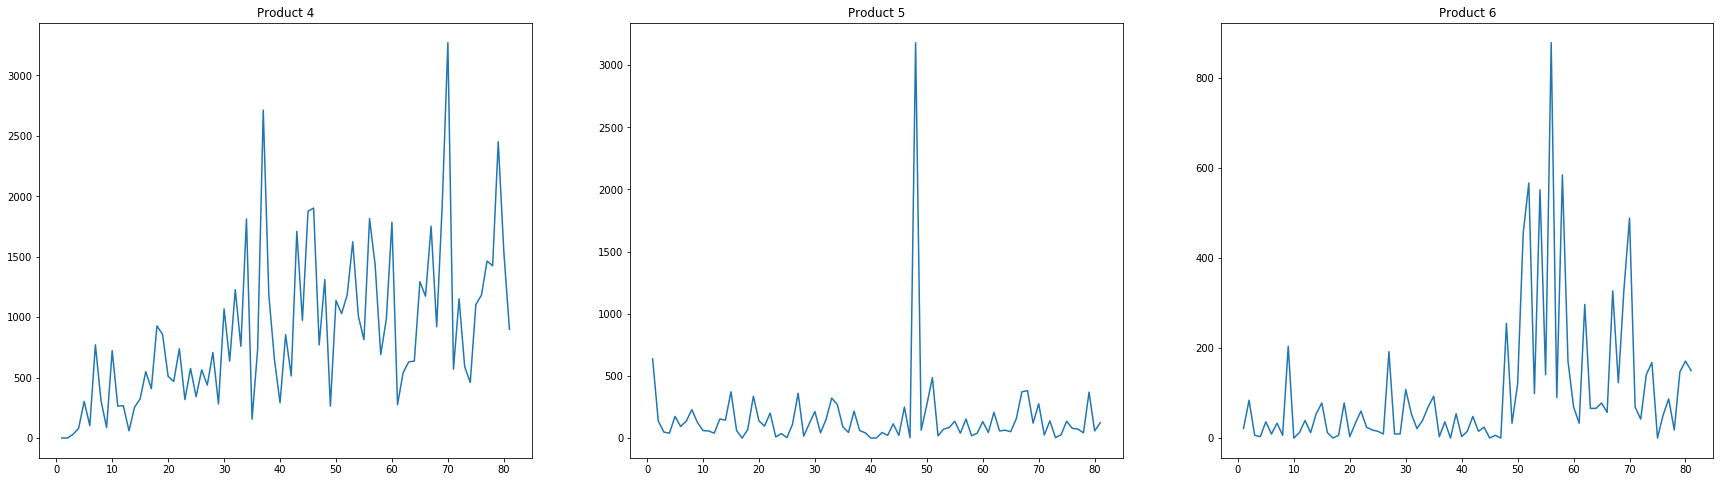

In [217]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 8));
axes[0].plot(data["Period"],data["Actual 4"]);
axes[0].set_title("Product 4");
axes[1].plot(data["Period"],data["Actual 5"]);
axes[1].set_title("Product 5");
axes[2].plot(data["Period"],data["Actual 6"]);
axes[2].set_title("Product 6");

### ARIMA Product #1

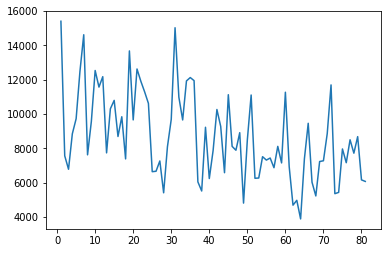

In [218]:
#We can see that Sales dataset has a clear trend. This suggests that the time series is not stationary and 
#will require differencing to make it stationary, at least a difference order of 1.
plt.plot(data["Period"],data["Actual 1"]);

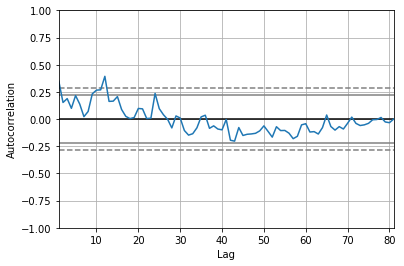

In [221]:
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
#Let’s also take a quick look at an autocorrelation plot of the time series. 
#We can see that there is no significant correlation with the lags 
#A good starting point for the AR parameter of the model may be 0.
autocorrelation_plot(data["Actual 1"]);

count       81.000000
mean      8701.000000
std       2573.329633
min       3885.000000
25%       6867.000000
50%       8109.000000
75%      10611.000000
max      15396.000000
Name: Actual 1, dtype: float64

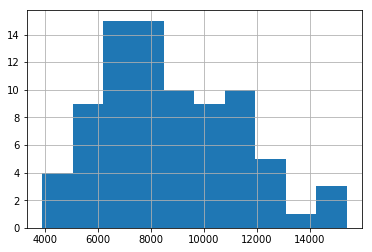

In [222]:
itog1 = data["Actual 1"].describe()
data["Actual 1"].hist()
itog1


Как можно заметить из характеристик и гистограммы, ряд у нас более менее однородный и имеет относительно небольшой разброс о чем свидетельствует коэффициент вариации: LaTeX:V = \frac {\sigma}{\bar{x}}, где LaTeX:\sigma — cреднеквадратическое отклонение, LaTeX:\bar{x} — среднее арифметическое выборки. В нашем случае он равен:

In [223]:
print("V = %f" % (itog1['std']/itog1['mean']))

V = 0.295751


Проведем тест Харки — Бера для определения номарльности распределения, чтобы подтвердить предположение об однородности. Для этого в существует функция jarque_bera(), которая возвращает значения данной статистики:

In [224]:
from statsmodels.iolib.table import SimpleTable
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(data["Actual 1"])
a = np.vstack([jb_test])
itog1 = SimpleTable(a, row)
print (itog1)

        JB              p-value              skew             kurtosis    
--------------------------------------------------------------------------
4.129141934193261 0.12687271146073986 0.5312955023853093 2.692835844272553
--------------------------------------------------------------------------


#https://habr.com/post/207160/
#Значение данной статистика свидетельствует о том, нулевая гипотеза о нормальности распределения отвергается с малой вероятностью (probably > 0.05), и, следовательно, наш ряд имеет нормального распределения.

Многие методы и модели основаны на предположениях о стационарности ряда, но как было замечено ранее наш ряд таковым скорее всего не является. Поэтому для проверки проверки стационарности давайте проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. Для этого в модуле statsmodels есть функция adfuller():

In [225]:
test = sm.tsa.adfuller(data["Actual 1"])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -1.1959277005037998
p-value:  0.6753450544181213
Critical values:  {'1%': -3.528889992207215, '5%': -2.9044395987933362, '10%': -2.589655654274312}
есть единичные корни, ряд не стационарен


Проведенный тест подтвердил предположения о не стационарности ряда. Во многих случаях взятие разности рядов позволяет это сделать.Если, например, первые разности ряда стационарны, то он называется интегрированным рядом первого порядка.
Итак, давайте определим порядок интегрированного ряда для нашего ряда:

In [226]:
ts1 = data["Actual 1"].diff(periods=1).dropna()

В коде выше функция diff() вычисляет разность исходного ряда с рядом с заданным смещением периода. Период смещения передается как параметр period. Т.к. в разности первое значение получиться неопределенным, то нам надо избавиться от него для этого и используется метод dropna().
Проверим получившийся ряд на стационарность:


In [227]:
test = sm.tsa.adfuller(ts1)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -4.40005473601858
p-value:  0.00029676642127906427
Critical values:  {'1%': -3.5319549603840894, '5%': -2.905755128523123, '10%': -2.5903569458676765}
единичных корней нет, ряд стационарен


Как видно из кода выше получившийся ряд первых разностей приблизился к стационарному. Для полной уверенности разобъем его на несколько промежутков и убедимся мат. ожидания на разных интервалах:

In [228]:
m = ts1.index[int(len(ts1.index)/2+1)]
r1 = sm.stats.DescrStatsW(ts1[m:])
r2 = sm.stats.DescrStatsW(ts1[:m])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.9236130776032336


Высокое p-value дает нам возможность утверждать, что нулевая гипотеза о равенстве средних верна, что свидетельствует о стационарности ряда. Осталось убедиться в отсутствии тренда для этого построим график нашего нового ряда:

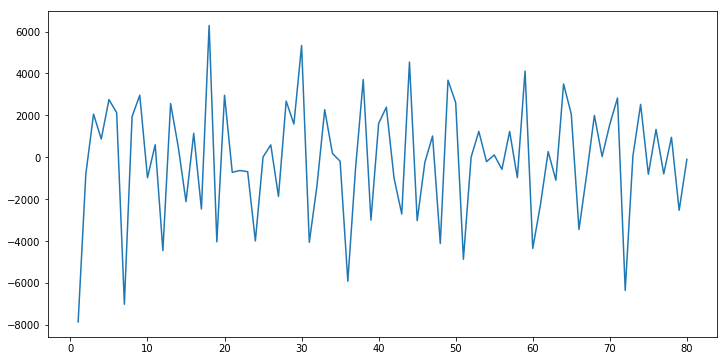

In [229]:
ts1.plot(figsize=(12,6));

Тренд действительно отсутствует, таким образом ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка.
Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA

Параметр d есть и он равет 1, осталось определить p и q. Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.
ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.
Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: plot_acf() и plot_pacf(). Они выводят графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов. Итак, наши функции выглядят так:

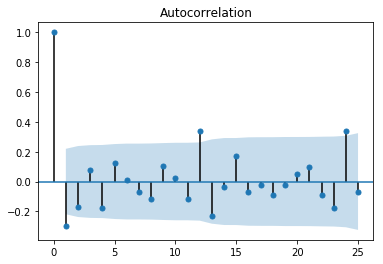

In [230]:
#ig = plt.figure(figsize=(12,8))
#ax1 = fig.add_subplot(211)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts1,lags=25);

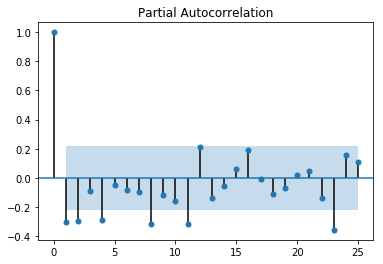

In [231]:
#ax2 = fig.add_subplot(212)
plot_pacf(ts1, lags=25);

После изучения коррелограммы PACF можно сделать вывод, что p = 1, т.к. на ней только 1 лаг сильно отличнен от нуля. По коррелограмме ACF можно увидеть, что q = 1, т.к. после лага 1 значении функций резко падают.
Итак, когда известны все параметры можно построить модель, но для ее построения мы возмем не все данные, а только часть. Данные из части не попавших в модель мы оставим для проверки точности прогноза нашей модели:

In [232]:
ts1_model = data["Actual 1"][:70]
model1 = sm.tsa.ARIMA(ts1_model, order=(1,1,1)).fit(disp=0)

In [233]:
print (model1.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Actual 1   No. Observations:                   69
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -631.945
Method:                       css-mle   S.D. of innovations           2234.411
Date:                Tue, 19 Mar 2019   AIC                           1271.889
Time:                        15:47:03   BIC                           1280.826
Sample:                             1   HQIC                          1275.435
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -67.0104     16.254     -4.123      0.000     -98.868     -35.153
ar.L1.D.Actual 1     0.1942      0.122      1.588      0.117      -0.046       0.434
ma.L1.D.Actual 1    -0.9999 

Как видно из данной информации в нашей модели все коэффициенты значимые и можно перейти к оценке модели.

Проверим остатки данной модели на соответствие «белому шуму», а также проанализируем коррелограму остатков, так как это может нам помочь в определении важных для включения и прогнозирования элементов регрессии.
Итак первое, что мы сделаем это проведем Q-тест Льюнга — Бокса для проверки гипотезы о том, что остатки случайны, т. е. являются «белым шумом». Данный тест проводится на остатках модели ARIMA. Таким образом, нам надо сначала получить остатки модели и построить для них ACF, а затем к получившимся коэффициентам приметить тест. С помощью statsmadels это можно сделать так:

In [234]:
q_test = sm.tsa.stattools.acf(model1.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print (pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    0.533892  0.464975
1    0.923228  0.630265
2    0.956253  0.811836
3    3.670121  0.452486
4    3.785256  0.580729
5    5.364380  0.497997
6    8.168993  0.317929
7    9.456363  0.305271
8    9.735012  0.372360
9   10.225666  0.420923
10  10.278176  0.505552
11  16.961256  0.151061
12  17.258724  0.187745
13  17.335174  0.238756
14  19.926081  0.174787
15  20.071626  0.217012
16  21.687831  0.197024
17  24.679314  0.134007
18  25.895700  0.133122
19  25.897275  0.169231
20  25.992805  0.206724
21  26.400971  0.234865
22  26.402496  0.282236
23  38.451436  0.031153
24  39.964638  0.029409
25  40.611149  0.033945
26  40.617046  0.044809
27  42.700723  0.037193
28  42.792487  0.047578
29  43.106669  0.057338
30  44.093685  0.059883
31  47.087364  0.041647
32  50.974285  0.023682
33  51.244573  0.029145
34  54.943927  0.017164
35  59.124966  0.008906
36  59.344537  0.011310
37  59.961885  0.013041
38  60.787528  0.014306
39  62.295222  0.013532


Значение данной статистики и p-values, свидетельствуют о том, что гипотеза о случайности остатков не отвергается, и скорее всего данный процесс представляет «белый шум».
Теперь давайте расчитаем коэффициент детерминацииLaTeX:R^2, чтобы понять какой процент наблюдений описывает данная модель:

In [235]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
pred1 = model1.predict(69,80,typ="levels")
trn1 = data["Actual 1"][69:]
r2 = r2_score(trn1, pred1)
print ('R^2: %1.2f' % r2)

R^2: -0.56


In [236]:
pred1.shape

(12,)

In [237]:
trn1.shape

(12,)

In [238]:
mean_squared_error(trn1,pred1)

4527339.8347870195

In [239]:
mean_absolute_error(trn1,pred1)

1659.4272002384578

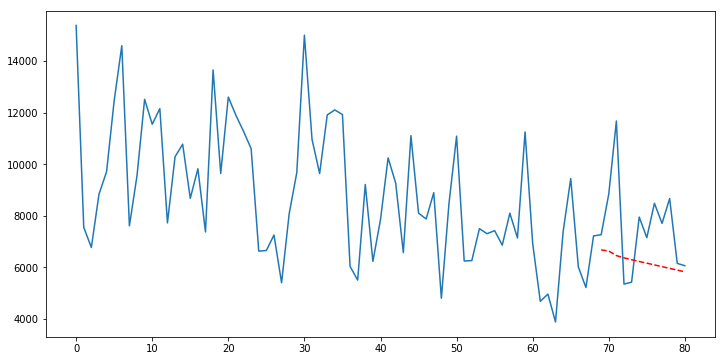

In [240]:
data["Actual 1"].plot(figsize=(12,6))
pred1.plot(style='r--');

# MAPE, GMRAE, UMBRAE

In [241]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [242]:
round(mean_absolute_percentage_error(trn1, pred1), 2)

19.81

In [243]:
def gmrae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true1 = np.array(data["Actual 1"][68:80])
    return (np.prod(np.abs((y_true - y_pred)/(y_true - y_true1))))**(1/len(y_true))

In [244]:
round(gmrae(trn1, pred1), 2)

1.52

In [245]:
len(trn1)

12

In [246]:
np.array(trn1)

array([ 7272,  8853, 11688,  5355,  5430,  7959,  7158,  8493,  7713,
        8676,  6159,  6069])

In [247]:
data["Actual 1"][68:80]

68     7227
69     7272
70     8853
71    11688
72     5355
73     5430
74     7959
75     7158
76     8493
77     7713
78     8676
79     6159
Name: Actual 1, dtype: int64

In [248]:
pred1

69    6683.984448
70    6638.768052
71    6461.814504
72    6373.456445
73    6302.300954
74    6234.485683
75    6167.318981
76    6100.278212
77    6033.261896
78    5966.250327
79    5899.239680
80    5832.229213
dtype: float64

In [249]:
def umbrae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true1 = np.array(data["Actual 1"][68:80])
    return (np.sum(np.abs(y_true - y_pred)/(np.abs(y_true - y_pred)+np.abs(y_true - y_true1))))/len(y_true)

In [250]:
round(umbrae(trn1, pred1), 2)

0.59

### DOUBLE Exponentional smoothing Product #1

In [251]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

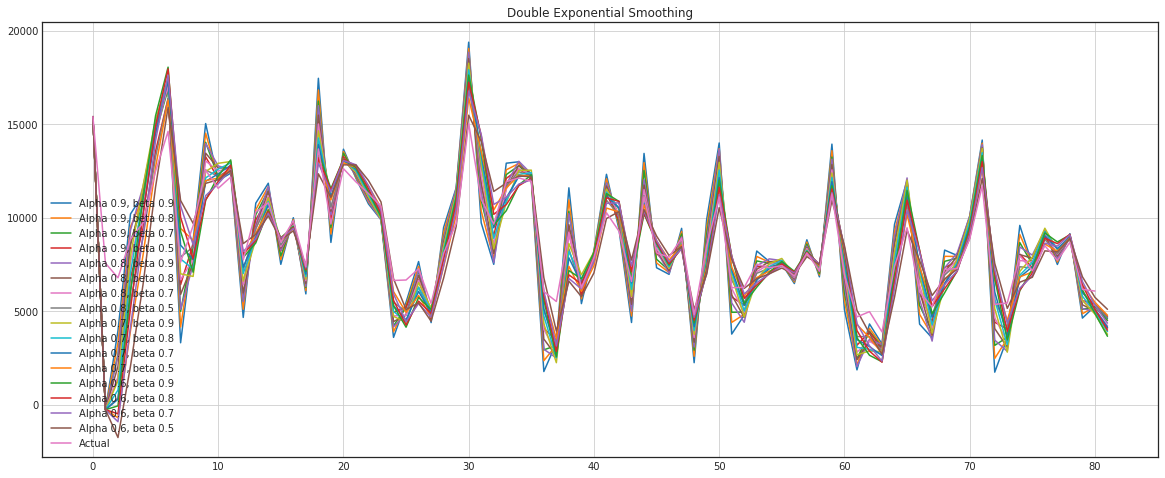

In [252]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.8,0.7,0.6]:
        for beta in [0.9, 0.8,0.7,0.5]:
            plt.plot(double_exponential_smoothing(data["Actual 1"], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(data["Actual 1"].values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

Now we have to tune two parameters — α and β. The former is responsible for the series smoothing around trend, and the latter for the smoothing of the trend itself. The bigger the values, the more weight the latest observations will have and the less smoothed the model series will be. Combinations of the parameters may produce really weird results, especially if set manually. We’ll look into choosing parameters automatically in a bit, immediately after triple exponential smoothing.

In [253]:
double_exponential_smoothing(data["Actual 1"],0.9,0.1)[69:81]

[7260.76626828314,
 8852.18628635017,
 11818.051522385358,
 5833.263408974195,
 5265.990890825401,
 7727.734458836235,
 7201.732714342057,
 8466.846595601855,
 7823.511790123667,
 8702.602248464718,
 6296.287091937,
 5954.199738009898]

In [254]:
data["Actual 1"][69:81]

69     7272
70     8853
71    11688
72     5355
73     5430
74     7959
75     7158
76     8493
77     7713
78     8676
79     6159
80     6069
Name: Actual 1, dtype: int64

In [255]:
for alpha in [0.9, 0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
        for beta in [0.9, 0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
            mape=mean_absolute_percentage_error(data["Actual 1"][69:81], double_exponential_smoothing(data["Actual 1"],alpha,beta)[69:81])
            print(alpha,"  ",beta,"  ", round(mape,3))

0.9    0.9    18.976
0.9    0.8    16.702
0.9    0.7    14.179
0.9    0.6    11.617
0.9    0.5    8.941
0.9    0.4    6.471
0.9    0.3    4.151
0.9    0.2    2.877
0.9    0.1    1.909
0.8    0.9    16.1
0.8    0.8    13.528
0.8    0.7    11.296
0.8    0.6    8.929
0.8    0.5    7.155
0.8    0.4    5.854
0.8    0.3    4.857
0.8    0.2    3.856
0.8    0.1    3.751
0.7    0.9    13.325
0.7    0.8    11.569
0.7    0.7    10.176
0.7    0.6    8.782
0.7    0.5    7.787
0.7    0.4    6.754
0.7    0.3    5.598
0.7    0.2    5.441
0.7    0.1    6.487
0.6    0.9    12.926
0.6    0.8    11.89
0.6    0.7    10.748
0.6    0.6    9.57
0.6    0.5    8.429
0.6    0.4    7.485
0.6    0.3    7.728
0.6    0.2    8.521
0.6    0.1    9.239
0.5    0.9    13.445
0.5    0.8    12.315
0.5    0.7    11.032
0.5    0.6    10.219
0.5    0.5    10.123
0.5    0.4    10.554
0.5    0.3    10.986
0.5    0.2    11.415
0.5    0.1    11.827
0.4    0.9    13.637
0.4    0.8    13.719
0.4    0.7    13.635
0.4    0.6    13.68

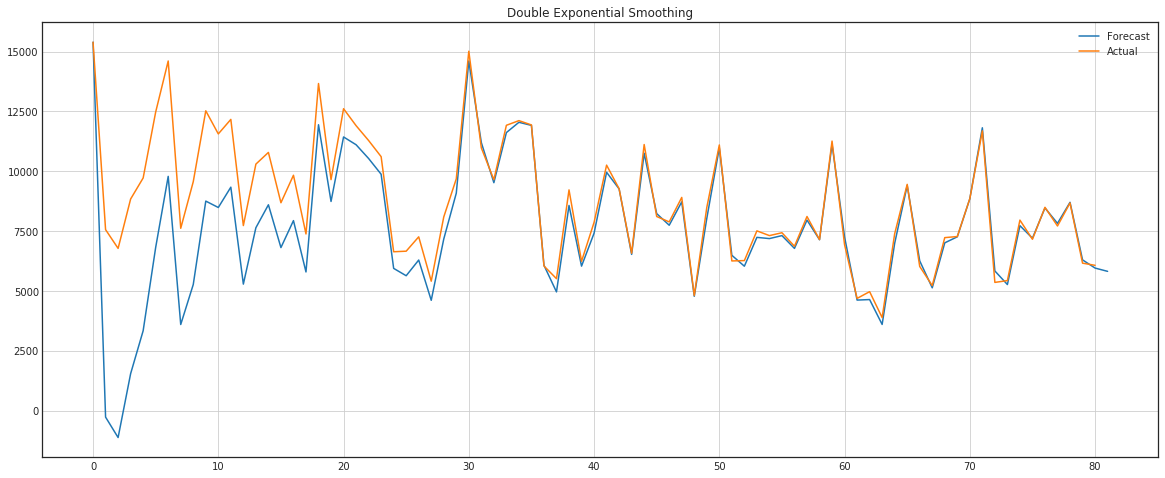

In [258]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(double_exponential_smoothing(data["Actual 1"], 0.9, 0.1), label = "Forecast");
    plt.plot(data["Actual 1"].values, label = "Actual");
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [259]:
round(mean_absolute_percentage_error(data["Actual 1"][69:81], 
                                     double_exponential_smoothing(data["Actual 1"],0.9,0.1)[69:81]),3)

1.909

In [260]:
round(gmrae(data["Actual 1"][69:81], 
                                     double_exponential_smoothing(data["Actual 1"],0.9,0.1)[69:81]),3)

0.074

In [261]:
round(umbrae(data["Actual 1"][69:81], 
                                     double_exponential_smoothing(data["Actual 1"],0.9,0.1)[69:81]),3)

0.16

## LINEAR REGRESSION

In [268]:
# Creating a copy of the initial datagrame to make various transformations 
xg = pd.DataFrame(data["Actual 1"].copy())
xg.columns = ["y"]

# Adding the lag of the target variable from 6 steps back up to 24
for i in range(1, 13):
    xg["lag_{}".format(i)] = xg.y.shift(i)

In [269]:
xg.head(13)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,15396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7560,15396.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6777,7560.0,15396.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8841,6777.0,7560.0,15396.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9720,8841.0,6777.0,7560.0,15396.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,12477,9720.0,8841.0,6777.0,7560.0,15396.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,14610,12477.0,9720.0,8841.0,6777.0,7560.0,15396.0,NaN,NaN,NaN,NaN,NaN,NaN
7,7617,14610.0,12477.0,9720.0,8841.0,6777.0,7560.0,15396.0,NaN,NaN,NaN,NaN,NaN
8,9564,7617.0,14610.0,12477.0,9720.0,8841.0,6777.0,7560.0,15396.0,NaN,NaN,NaN,NaN
9,12528,9564.0,7617.0,14610.0,12477.0,9720.0,8841.0,6777.0,7560.0,15396.0,NaN,NaN,NaN


In [270]:
xg=xg.dropna()

In [271]:
y = xg["y"]
X = xg.drop(["y"], axis=1)

In [273]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [276]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_squared_error")
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std())
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    

In [285]:
# reserve 15% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.17)

In [286]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

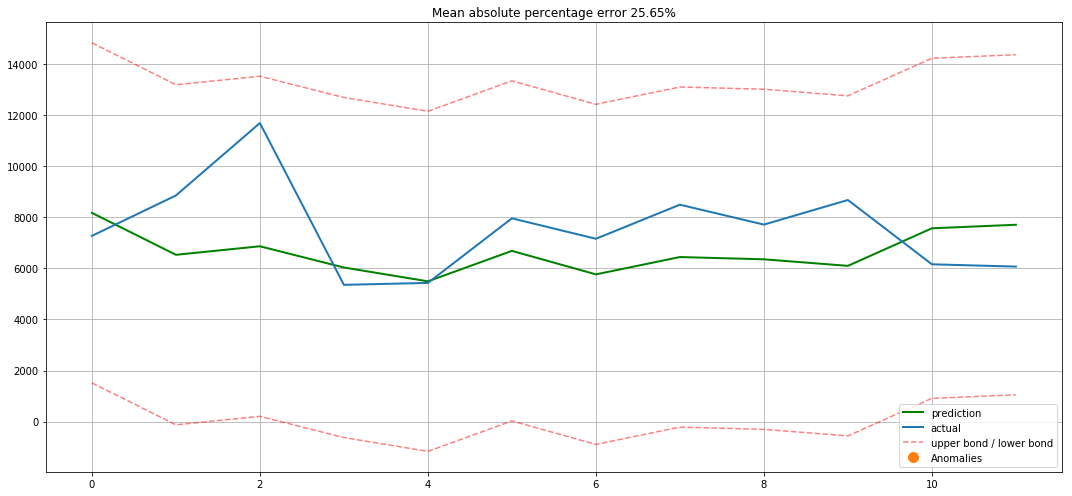

In [287]:
plotModelResults(lr, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

In [288]:
prediction = lr.predict(X_test)
print (prediction)

[8172.19051151 6530.75931266 6864.61666205 6033.14489111 5492.23442733
 6684.44843756 5764.52102066 6443.13019145 6354.15193878 6098.25726672
 7568.31795931 7706.87345186]


In [296]:
print (y_test)

69     7272
70     8853
71    11688
72     5355
73     5430
74     7959
75     7158
76     8493
77     7713
78     8676
79     6159
80     6069
Name: y, dtype: int64


In [308]:
round(mean_absolute_percentage_error(y_test, prediction),2)

20.88

In [309]:
round(gmrae(y_test, prediction), 2)

1.6

In [310]:
round(umbrae(y_test, prediction), 2)

0.58

## XGBOOST 

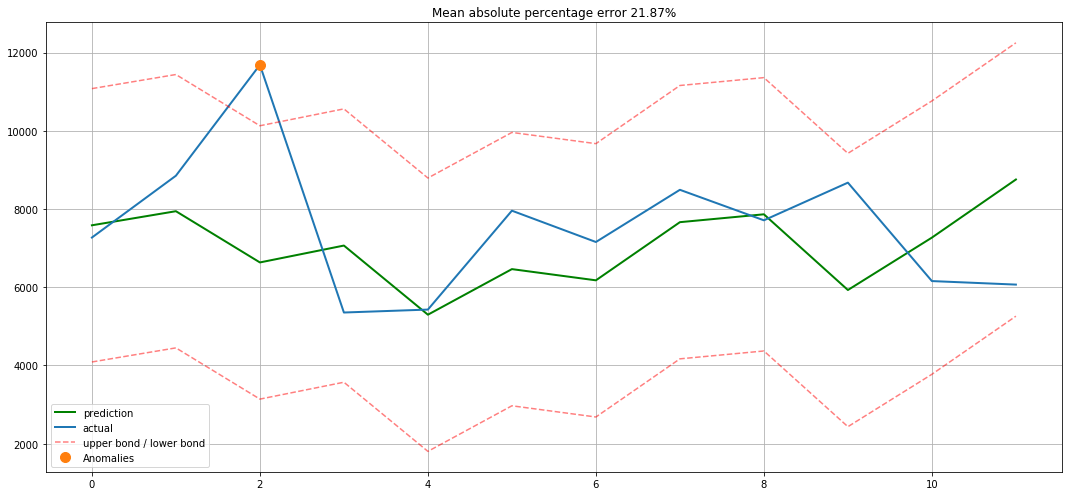

In [299]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

plotModelResults(xgb, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

In [303]:
prediction1 = xgb.predict(X_test)
print (prediction1)

[7585.4106 7945.7617 6635.6777 7067.23   5299.137  6464.7363 6178.2075
 7665.2773 7866.4434 5930.4146 7270.4756 8756.422 ]


In [311]:
round(mean_absolute_percentage_error(y_test, prediction1),2)

19.19

In [304]:
round(gmrae(y_test, prediction1), 2)

1.22

In [305]:
round(umbrae(y_test, prediction1), 2)

0.52

# Facebook Prophet

In [312]:
from fbprophet import Prophet

In [313]:
ph1=pd.read_csv("For USML_date2.csv", sep=";")
ph1.tail(12)

,Date,Actual 1,Actual 2,Actual 3,Actual 4,Actual 5,Actual 6
69,31.07.2017,7272,1584,3933,3270,276,489
70,31.08.2017,8853,1125,4938,570,24,69
71,30.09.2017,11688,894,3381,1152,138,42
72,31.10.2017,5355,1266,2391,591,3,141
73,30.11.2017,5430,636,1179,459,27,168
74,31.12.2017,7959,678,2130,1104,135,0
75,31.01.2018,7158,654,1668,1182,78,51
76,28.02.2018,8493,183,3501,1464,72,87
77,31.03.2018,7713,945,4980,1425,42,18
78,30.04.2018,8676,3966,4011,2451,369,147


In [314]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [315]:
import pandas as pd
ph1 = pd.DataFrame({'ds':ph1['Date'], 'y':ph1["Actual 1"]})

In [316]:
prediction_size = 12
train_df = ph1[:-prediction_size]
train_df.tail(n=3)

,ds,y
66,30.04.2017,6021
67,31.05.2017,5223
68,30.06.2017,7227


In [317]:
m = Prophet()
m.fit(train_df)
predictions=12
future = m.make_future_dataframe(periods=predictions, freq='M')
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [318]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
76,2018-02-28,5142.700306,2823.697699,6861.501604,5142.642582,5142.755361,-326.089693,-326.089693,-326.089693,-326.089693,-326.089693,-326.089693,0.0,0.0,0.0,4816.610613
77,2018-03-31,5053.365102,6155.322148,9862.648750,5053.294373,5053.432975,2953.496899,2953.496899,2953.496899,2953.496899,2953.496899,2953.496899,0.0,0.0,0.0,8006.862001
78,2018-04-30,4966.911679,4689.013542,8817.265120,4966.829989,4966.992948,1851.748666,1851.748666,1851.748666,1851.748666,1851.748666,1851.748666,0.0,0.0,0.0,6818.660345
79,2018-05-31,4877.576475,1087.966468,4825.569389,4877.482112,4877.671100,-1839.611006,-1839.611006,-1839.611006,-1839.611006,-1839.611006,-1839.611006,0.0,0.0,0.0,3037.965468
80,2018-06-30,4791.123051,4125.556109,8010.660864,4791.014873,4791.232423,1239.363502,1239.363502,1239.363502,1239.363502,1239.363502,1239.363502,0.0,0.0,0.0,6030.486553


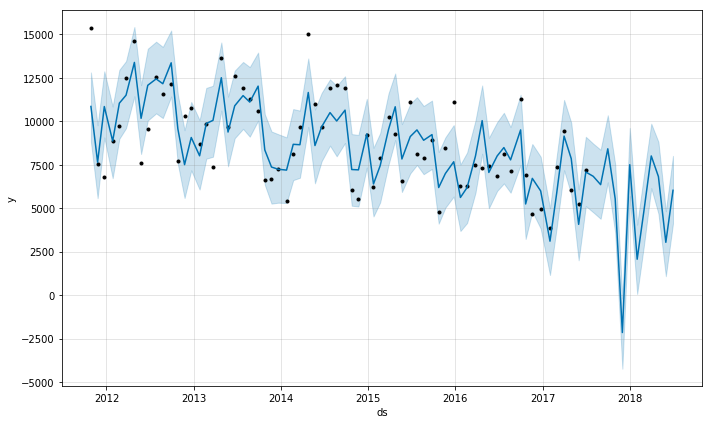

In [319]:
m.plot(forecast);

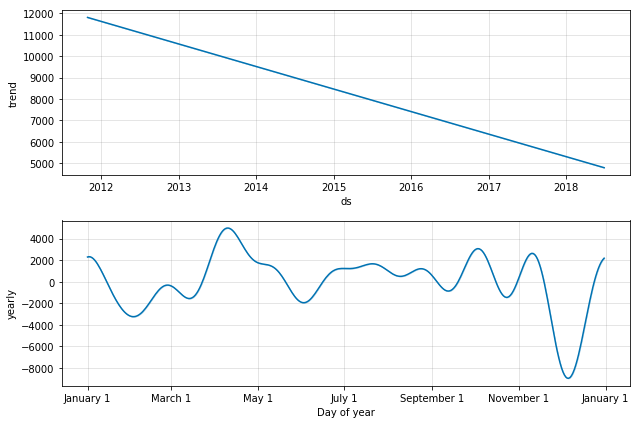

In [320]:
m.plot_components(forecast);

In [321]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index("ds"))

In [322]:
cmp_df = make_comparison_dataframe(ph1, forecast)
cmp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2018-02-28,4816.610613,2823.697699,6861.501604,8493
2018-03-31,8006.862001,6155.322148,9862.648750,7713
2018-04-30,6818.660345,4689.013542,8817.265120,8676
2018-05-31,3037.965468,1087.966468,4825.569389,6159
2018-06-30,6030.486553,4125.556109,8010.660864,6069


In [323]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [324]:
for err_name, err_value in calculate_forecast_errors(cmp_df, predictions).items():
    print(err_name, err_value)

MAPE 33.49763339148836
MAE 2375.6108603514863


In [345]:
cmp_df['y'][-12:]

ds
2017-07-31     7272
2017-08-31     8853
2017-09-30    11688
2017-10-31     5355
2017-11-30     5430
2017-12-31     7959
2018-01-31     7158
2018-02-28     8493
2018-03-31     7713
2018-04-30     8676
2018-05-31     6159
2018-06-30     6069
Name: y, dtype: int64

In [346]:
cmp_df['yhat'][-12:]

ds
2017-07-31    6835.610209
2017-08-31    6356.406902
2017-09-30    8417.364073
2017-10-31    5539.602483
2017-11-30   -2152.238143
2017-12-31    7502.400857
2018-01-31    2064.867282
2018-02-28    4816.610613
2018-03-31    8006.862001
2018-04-30    6818.660345
2018-05-31    3037.965468
2018-06-30    6030.486553
Name: yhat, dtype: float64

In [347]:
round(mean_absolute_percentage_error(cmp_df['y'][-12:], cmp_df['yhat'][-12:]),2)

33.5

In [348]:
round(gmrae(cmp_df['y'][-12:], cmp_df['yhat'][-12:]), 2)

1.41

In [349]:
round(umbrae(cmp_df['y'][-12:], cmp_df['yhat'][-12:]), 2)

0.55